In [3]:
import causalnex
import pandas as pd
import numpy as np
from numpy import asarray

#for splitting, scaling and encoding
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

#for pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

#for drawing causal graph
from causalnex.structure.notears import from_pandas

# Extract Causal Blanket
from causalnex.structure import StructureModel
from causalnex.network import BayesianNetwork
from causalnex.discretiser import Discretiser
from causalnex.discretiser.discretiser_strategy import ( DecisionTreeSupervisedDiscretiserMethod )
from causalnex.evaluation import classification_report,roc_auc

import warnings
from pandas import DataFrame
warnings.filterwarnings("ignore")

In [4]:
data = pd.read_csv("../data/data2.csv")
data.drop("Unnamed: 0", axis=1, inplace = True)

In [5]:
data

,texture_mean,area_mean,smoothness_mean,concavity_mean,fractal_dimension_mean,area_se,smoothness_se,concavity_se,fractal_dimension_se,smoothness_worst,concavity_worst,symmetry_worst,fractal_dimension_worst,diagnosis
0,10.38,1001.0,0.11840,0.30010,0.07871,153.40,0.006399,0.05373,0.006193,0.16220,0.7119,0.4601,0.11890,M
1,17.77,1326.0,0.08474,0.08690,0.05667,74.08,0.005225,0.01860,0.003532,0.12380,0.2416,0.2750,0.08902,M
2,21.25,1203.0,0.10960,0.19740,0.05999,94.03,0.006150,0.03832,0.004571,0.14440,0.4504,0.3613,0.08758,M
3,20.38,386.1,0.14250,0.24140,0.09744,27.23,0.009110,0.05661,0.009208,0.20980,0.6869,0.6638,0.17300,M
4,14.34,1297.0,0.10030,0.19800,0.05883,94.44,0.011490,0.05688,0.005115,0.13740,0.4000,0.2364,0.07678,M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,22.39,1479.0,0.11100,0.24390,0.05623,158.70,0.010300,0.05198,0.004239,0.14100,0.4107,0.2060,0.07115,M
565,28.25,1261.0,0.09780,0.14400,0.05533,99.04,0.005769,0.03950,0.002498,0.11660,0.3215,0.2572,0.06637,M
566,28.08,858.1,0.08455,0.09251,0.05648,48.55,0.005903,0.04730,0.003892,0.11390,0.3403,0.2218,0.07820,M
567,29.33,1265.0,0.11780,0.35140,0.07016,86.22,0.006522,0.07117,0.006185,0.16500,0.9387,0.4087,0.12400,M


### split data set to training and holdout set and return the training dataset

In [6]:

def labeler(df, col):
    """
    A function that change categorical to numerical
    """
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    return(df)

In [7]:
def splitter(df, rand=20, test=.2, split='t'):
    """
    A function to split the dataset to test and holdout set
    """
    train_df, valid_df = train_test_split(df, random_state=rand, test_size=test)
    if(split=='t'):
        return (train_df)
    else:
        return(valid_df)

In [9]:
def scaler(df):
    """
    A function that scale a dataset
    """
    scaler = MinMaxScaler()
    # transform data
    scaled = scaler.fit_transform(df)
    print(df.shape)
    return (scaled)
    

In [10]:
def rename_col(sc):
    """
    A function that rename scaled columns
    to their original name
    """
    df = DataFrame(sc)
    dic={}
    for i in range(len(df.columns.to_list())):
        dic[i]=data.columns.to_list()[i]
    df.rename(columns = dic, inplace=True)
    return df

In [12]:
# a pipeline to process data and gives us the trained datasetset
pipe = Pipeline(steps=[("labeler", FunctionTransformer(labeler, kw_args={'col':'diagnosis'})),
    ("split", FunctionTransformer(splitter, kw_args={'rand':20, 'test':0.2, 'split':'t'})),
                        ("scaler", FunctionTransformer(scaler)),
                        ("rename_col", FunctionTransformer(rename_col))])

In [13]:
train_df = pipe.fit_transform(data)
train_df

(455, 14)


,texture_mean,area_mean,smoothness_mean,concavity_mean,fractal_dimension_mean,area_se,smoothness_se,concavity_se,fractal_dimension_se,smoothness_worst,concavity_worst,symmetry_worst,fractal_dimension_worst,diagnosis
0,0.391003,0.053150,0.293907,0.087512,0.401860,0.000000,0.129245,0.094318,0.127420,0.247177,0.149201,0.192682,0.242818,0.0
1,0.549827,1.000000,0.605735,0.851687,0.145814,1.000000,0.201822,0.203409,0.126556,0.426137,0.545767,0.255643,0.126131,1.0
2,0.205882,0.183245,0.435973,0.041050,0.269535,0.019514,0.071897,0.017874,0.027714,0.364723,0.096326,0.294844,0.149416,0.0
3,0.340138,0.227953,0.469643,0.159888,0.174884,0.028088,0.125846,0.054369,0.031687,0.333025,0.135783,0.191019,0.071822,0.0
4,0.469550,0.271135,0.340828,0.232849,0.079535,0.055618,0.273855,0.127551,0.072800,0.276894,0.185463,0.295557,0.051358,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
450,0.386851,0.460870,0.447486,0.298032,0.136047,0.219646,0.173063,0.087020,0.108833,0.423496,0.288898,0.357567,0.180441,1.0
451,0.341522,0.262057,0.541653,0.268744,0.303953,0.047419,0.103784,0.060202,0.077256,0.554910,0.317572,0.576859,0.336875,1.0
452,0.092042,0.103712,0.496470,0.076500,0.296279,0.011894,0.161777,0.032374,0.066408,0.426798,0.101837,0.277501,0.165158,0.0
453,0.181315,0.091368,0.522103,0.119845,0.428140,0.005220,0.093857,0.069621,0.130495,0.409628,0.268770,0.241388,0.347370,0.0


### causal graph with training dataset

In [14]:
from causalnex.structure.notears import from_pandas
from causalnex.plots import plot_structure, NODE_STYLE, EDGE_STYLE
from IPython.display import Image

def causal_graph(df):
    """
    A function to draw causal graph
    """
    viz = plot_structure(
        sm,
        graph_attributes={"scale": "0.8", "size": 1},
        all_node_attributes=NODE_STYLE.WEAK,
        all_edge_attributes=EDGE_STYLE.WEAK,)
    
    return(Image(viz.draw(format='png')))


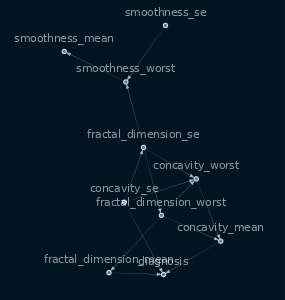

In [15]:
sm = from_pandas(train_df)
sm.remove_edges_below_threshold(0.8)
sm = sm.get_largest_subgraph()

causal_graph(train_df)

### create causal graph by increasing fraction of the data

* 80% of the data

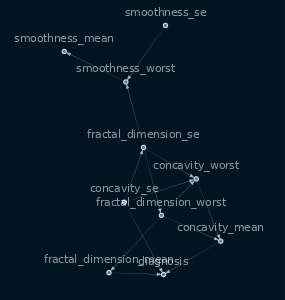

In [16]:
df1 = train_df[:int(len(train_df)*0.8)]

sm1 = from_pandas(df1)
sm1.remove_edges_below_threshold(0.8)
sm1 = sm1.get_largest_subgraph()
causal_graph(df1)

* 70% of the data

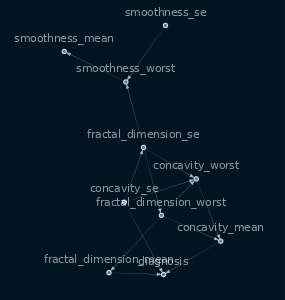

In [17]:
df2 = train_df[:int(len(train_df)*0.7)]

sm2 = from_pandas(df2)
sm2.remove_edges_below_threshold(0.8)
sm2 = sm2.get_largest_subgraph()
causal_graph(df2)

* 60% of the data

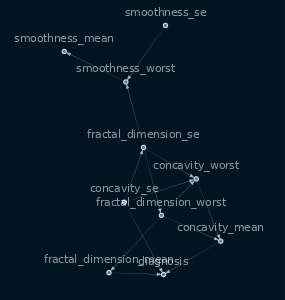

In [18]:
df3 = train_df[:int(len(train_df)*0.6)]

sm3 = from_pandas(df3)
sm3.remove_edges_below_threshold(0.8)
sm3 = sm3.get_largest_subgraph()
causal_graph(df3)

### ground truth causal graph vs. fractioned causal graph

In [19]:
def jaccard_set(list1, list2):
    """Define Jaccard Similarity function for two sets"""
    intersection = len(list(set(list1).intersection(list2)))
    union = (len(list1) + len(list2)) - intersection
    return float(intersection) / union


In [20]:
#100% vs 80%
jaccard_set(sm.edges, sm1.edges)

0.7058823529411765

In [21]:
#100% vs 70%
jaccard_set(sm.edges, sm2.edges)

0.7222222222222222

In [22]:
#100% vs 60%
jaccard_set(sm.edges, sm3.edges)

0.5909090909090909

### selected variables: fractal_dimension_mean, concavity_se, concavity_mean

In [23]:
blanket = sm.get_markov_blanket('diagnosis')
print(blanket.edges)

[('concavity_se', 'diagnosis'), ('fractal_dimension_mean', 'diagnosis'), ('concavity_mean', 'diagnosis')]


In [24]:
def var_parents():
    """
    A function to return the nodes directly pointing at the target
    """
    selected = set()
    for item in blanket.edges:
        for val in item:
            if(val != "diagnosis"):
                selected.add(val)
    selected = list(selected)
    return(selected)

In [25]:
selected = var_parents()
sel_ft = pd.DataFrame()
sel_ft[selected] = train_df[selected]
sel_ft['diagnosis'] = train_df['diagnosis']

In [26]:
sel_ft

,concavity_se,concavity_mean,fractal_dimension_mean,diagnosis
0,0.094318,0.087512,0.401860,0.0
1,0.203409,0.851687,0.145814,1.0
2,0.017874,0.041050,0.269535,0.0
3,0.054369,0.159888,0.174884,0.0
4,0.127551,0.232849,0.079535,1.0
...,...,...,...,...
450,0.087020,0.298032,0.136047,1.0
451,0.060202,0.268744,0.303953,1.0
452,0.032374,0.076500,0.296279,0.0
453,0.069621,0.119845,0.428140,0.0


### Train model with all variables

In [27]:
def descreter(df, feat):
    """
    A function that changes df to discrete to be accecpted
    by Bayseian network
    """
    from causalnex.discretiser.discretiser_strategy import (
        DecisionTreeSupervisedDiscretiserMethod,
    )
    tree_discretiser = DecisionTreeSupervisedDiscretiserMethod(
        mode="single", 
        tree_params={"max_depth": 2, "random_state": 2022},
    )
    tree_discretiser.fit(
        feat_names=feat, 
        dataframe=df, 
        target_continuous=True,
        target="diagnosis",
    )
    desc_df = df.copy()
    for col in df.columns.to_list():
        desc_df[col] = tree_discretiser.transform(desc_df[[col]])
        
    return(desc_df)

In [28]:
desc_df1= descreter(train_df, train_df.columns.to_list())
desc_df1

,texture_mean,area_mean,smoothness_mean,concavity_mean,fractal_dimension_mean,area_se,smoothness_se,concavity_se,fractal_dimension_se,smoothness_worst,concavity_worst,symmetry_worst,fractal_dimension_worst,diagnosis
0,3,0,0,0,3,0,0,2,3,0,0,0,1,0
1,3,3,3,3,2,3,0,2,3,1,3,0,0,1
2,0,1,2,0,2,0,0,0,1,1,0,0,0,0
3,2,1,2,0,2,1,0,2,1,1,0,0,0,0
4,3,2,1,2,1,2,0,2,2,1,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
450,3,3,2,3,2,3,0,2,3,1,2,2,1,1
451,2,2,2,2,2,2,0,2,2,2,3,3,3,1
452,0,0,2,0,2,0,0,1,2,1,0,0,1,0
453,0,0,2,0,3,0,0,2,3,1,2,0,3,0


In [30]:
# create Bayesian Network
from causalnex.network import BayesianNetwork

def bayseian(df, sm=sm):
    """
    A function to create Bayesian Network
    """
    
    bn = BayesianNetwork(sm)
    bn = bn.fit_node_states(df)
    bn = bn.fit_cpds(
        desc_df, 
        method="BayesianEstimator", 
        bayes_prior="K2",
    )
    return df



In [92]:
bayseian(train_df, sm)

,texture_mean,area_mean,smoothness_mean,concavity_mean,fractal_dimension_mean,area_se,smoothness_se,concavity_se,fractal_dimension_se,smoothness_worst,concavity_worst,symmetry_worst,fractal_dimension_worst,diagnosis
0,3,0,0,0,3,0,0,2,3,0,0,0,1,0
1,3,3,3,3,2,3,0,2,3,1,3,0,0,1
2,0,1,2,0,2,0,0,0,1,1,0,0,0,0
3,2,1,2,0,2,1,0,2,1,1,0,0,0,0
4,3,2,1,2,1,2,0,2,2,1,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
450,3,3,2,3,2,3,0,2,3,1,2,2,1,1
451,2,2,2,2,2,2,0,2,2,2,3,3,3,1
452,0,0,2,0,2,0,0,1,2,1,0,0,1,0
453,0,0,2,0,3,0,0,2,3,1,2,0,3,0


In [93]:
bn.cpds["diagnosis"]

concavity_mean            0                                               \
concavity_se              0                                  1             
fractal_dimension_mean    0         1         2         3    0         1   
diagnosis                                                                  
0                       0.5  0.916667  0.985915  0.916667  0.5  0.545455   
1                       0.5  0.083333  0.014085  0.083333  0.5  0.454545   

concavity_mean                                        ...    3             \
concavity_se                             2            ...    1          2   
fractal_dimension_mean         2    3    0         1  ...    2    3     0   
diagnosis                                             ...                   
0                       0.929412  0.9  0.5  0.714286  ...  0.5  0.5  0.25   
1                       0.070588  0.1  0.5  0.285714  ...  0.5  0.5  0.75   

concavity_mean                                                       
concavity_se                                       3                 
fractal_dimension_mean    1         2         3    0    1    2    3  
diagnosis                                                            
0                       0.1  0.034483  0.132075  0.5  0.5  0.5  0.8  
1                       0.9  0.965517  0.867925  0.5  0.5  0.5  0.2  

[2 rows x 64 columns]

In [80]:
# save
import joblib
joblib.dump(bn, "../models/bayseain_all.pkl") 

['../models/bayseain_all.pkl']

### Train model with selcted variables

In [26]:
desc_df2 = descreter(sel_ft, sel_ft.columns.to_list())
desc_df2

,fractal_dimension_mean,concavity_mean,concavity_se,diagnosis
0,3,0,2,0
1,2,3,2,1
2,2,0,0,0
3,2,0,2,0
4,1,2,2,1
...,...,...,...,...
450,2,3,2,1
451,2,2,2,1
452,2,0,1,0
453,3,0,2,0


In [30]:
sm6 = from_pandas(sel_ft)

sm6.remove_edges_below_threshold(0.8)
sm6 = sm6.get_largest_subgraph()

In [39]:
bn = BayesianNetwork(sm6)
bayseian(df=desc_df2, sm=sm6, bn=bn)

,fractal_dimension_mean,concavity_mean,concavity_se,diagnosis
0,3,0,2,0
1,2,3,2,1
2,2,0,0,0
3,2,0,2,0
4,1,2,2,1
...,...,...,...,...
450,2,3,2,1
451,2,2,2,1
452,2,0,1,0
453,3,0,2,0


In [40]:
bn.cpds["diagnosis"]

concavity_mean         0                             1                      2  \
concavity_se           0         1         2    3    0      1     2    3    0   
diagnosis                                                                       
0               0.989011  0.901961  0.945205  0.5  0.5  0.125  0.72  0.5  0.5   
1               0.010989  0.098039  0.054795  0.5  0.5  0.875  0.28  0.5  0.5   

concavity_mean                             3                      
concavity_se           1         2    3    0    1         2    3  
diagnosis                                                         
0               0.333333  0.361702  0.5  0.5  0.5  0.067227  0.8  
1               0.666667  0.638298  0.5  0.5  0.5  0.932773  0.2

In [ ]:
# save
import joblib
joblib.dump(bn, "../models/bayseain_selected.pkl") 